In [1]:
import torch
import os
from pathlib import Path
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from mrnet.networks.mrnet import MRFactory
from mrnet.datasets.sampler import make_grid_coords

In [2]:
os.environ["WANDB_NOTEBOOK_NAME"] = "eval-net.ipynb"
BASE_DIR = Path('.').absolute().parents[0]
IMAGE_PATH = BASE_DIR.joinpath('img')
MODEL_PATH = BASE_DIR.joinpath('runs/tmp')

In [3]:
project_name = "test_eval"
with open('../configs/image.yml') as f:
    hyper = yaml.load(f, Loader=SafeLoader)

In [4]:
modelpath = os.path.join(MODEL_PATH,
                 "MGpic7._1-1_w128F_hf256256_MEp200_hl1_r512_pr4.pth"
                 )
# TODO: download model automatically from W&B if can't find it locally
if not os.path.exists(modelpath):
    pass
mrmodel = MRFactory.load_state_dict(
    # modelpath
    "E:/Workspace/impa/mrnet/runs/logs/MGhallpR_3-3_w32F_hf256384_MEp100_hl1_r256_pr2_20230907-1610/models/final.pth"
    )
print("Model: ", type(mrmodel))

MNet(
  (stages): ModuleList(
    (0): MRModule(
      (first_layer): SineLayer(
        (linear): Linear(in_features=2, out_features=128, bias=True)
      )
      (middle_layers): Sequential(
        (0): SineLayer(
          (linear): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (final_linear): Linear(in_features=128, out_features=3, bias=True)
    )
  )
)
Model:  <class 'mrnet.networks.mrnet.MNet'>


In [5]:
for p in mrmodel.parameters():
    print("p: ", p.shape, " = ", p.numel())
total_params = sum(p.numel() for p in mrmodel.parameters()) - mrmodel.n_stages()
print("TOTAL = ", total_params)
print("MODEL TOTAL = ", mrmodel.total_parameters())

p:  torch.Size([128, 2])  =  256
p:  torch.Size([128])  =  128
p:  torch.Size([256, 128])  =  32768
p:  torch.Size([256])  =  256
p:  torch.Size([3, 256])  =  768
p:  torch.Size([3])  =  3
p:  torch.Size([256, 2])  =  512
p:  torch.Size([256])  =  256
p:  torch.Size([256, 512])  =  131072
p:  torch.Size([256])  =  256
p:  torch.Size([3, 256])  =  768
p:  torch.Size([3])  =  3
p:  torch.Size([256, 2])  =  512
p:  torch.Size([256])  =  256
p:  torch.Size([384, 512])  =  196608
p:  torch.Size([384])  =  384
p:  torch.Size([3, 384])  =  1152
p:  torch.Size([3])  =  3
TOTAL =  365958
MODEL TOTAL =  365958


torch.Size([65536, 2])


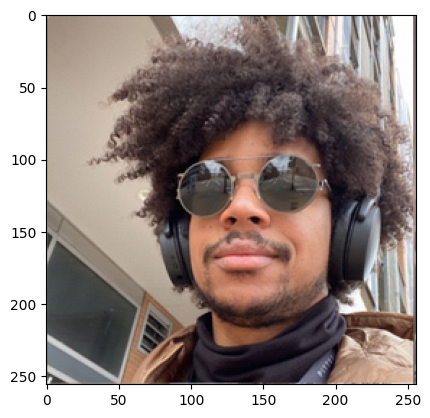

In [7]:
W = 256
input = make_grid_coords(W, *hyper['domain'], dim=2)
print(input.shape)
output = mrmodel(input)
model_out = torch.clamp(output['model_out'], 0.0, 1.0)
plt.imshow(model_out.cpu().view(W, W, -1).detach().numpy())

## Extrapolation

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, Box, interact_manual

In [ ]:
slider = widgets.FloatRangeSlider(
    value=[-1.0, 1.0],
    min=-7,
    max=7,
    step=0.1,
    description='Interval:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='50%')
)

model = mrmodel
res = 512
channels=1
def plot_model(interval):
    grid = make_grid_coords(res, *interval, dim=2)
    output = model(grid)
    model_out = torch.clamp(output['model_out'], 0.0, 1.0)

    pixels = model_out.cpu().detach().view(res, res, channels).numpy()
    pixels = (pixels * 255).astype(np.uint8)
    if channels == 1:
        pixels = np.repeat(pixels, 3, axis=-1)
    return Image.fromarray(pixels)

interact(plot_model, interval=slider)

## Continuous in Scale

In [ ]:
level_slider = widgets.FloatSlider(
        value=1.0,
        min=0.0,
        max=float(mrmodel.n_stages()),
        step=0.05,
        description=f'Multilevel',
        disabled=False,
        continuous_update=True,
        readout=True,
        orientation='horizontal',
        readout_format='.2f',
        layout=widgets.Layout(width='50%')
)
def plot_model(level):
    grid = make_grid_coords(res, res, -1.0, 1.0)
    weights = []
    for s in range(mrmodel.n_stages()):
        if level >= s + 1:
             weights.append(1.0)
        else:
             weights.append(max(level - s, 0.0))

    output = model(grid, mrweights=torch.Tensor(weights))
    model_out = torch.clamp(output['model_out'], 0.0, 1.0)

    pixels = model_out.cpu().detach().view(res, res, channels).numpy()
    pixels = (pixels * 255).astype(np.uint8)
    if channels == 1:
        pixels = np.repeat(pixels, 3, axis=-1)
    return Image.fromarray(pixels)

interact(plot_model, level=level_slider)